# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [464]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [465]:
import warnings

warnings.filterwarnings("ignore")

In [466]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [467]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [468]:
def ru(relevant: List[int], predicted: List[int], k: int = 20):
    return np.isin(predicted[:k], relevant)

def puk(relevant: List[int], predicted: List[int], k: int = 20):
    return np.cumsum(ru(relevant, predicted, k))/np.arange(1, k+1)

def apuk(relevant: List[int], predicted: List[int], k: int = 20):
    return np.sum(ru(relevant, predicted, k)*puk(relevant, predicted, k))/min(k, len(relevant))

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    sum = 0
    for u in range(len(relevant)):
        sum += apuk(relevant[u], predicted[u], k)
    return sum/len(relevant)

In [469]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [470]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [471]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [472]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [473]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [474]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [475]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [476]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [477]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [478]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.0

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        if len(new_preds) == 0:
            print('gg')
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user in range(self.n_users):
            test_preds.append(self.recommend(user))
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [479]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.logical_and(user_vector, ratings).sum(axis=1)
    union = np.logical_or(user_vector, ratings).sum(axis=1)
    similarity = intersection/union
    similarity[union == 0] = 0

    return similarity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [480]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        sim[uid] = 0
        sim_users_indexes = np.where(sim > self.alpha)[0]

        return np.argsort(-sim[sim_users_indexes] @ self.R[sim_users_indexes])

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

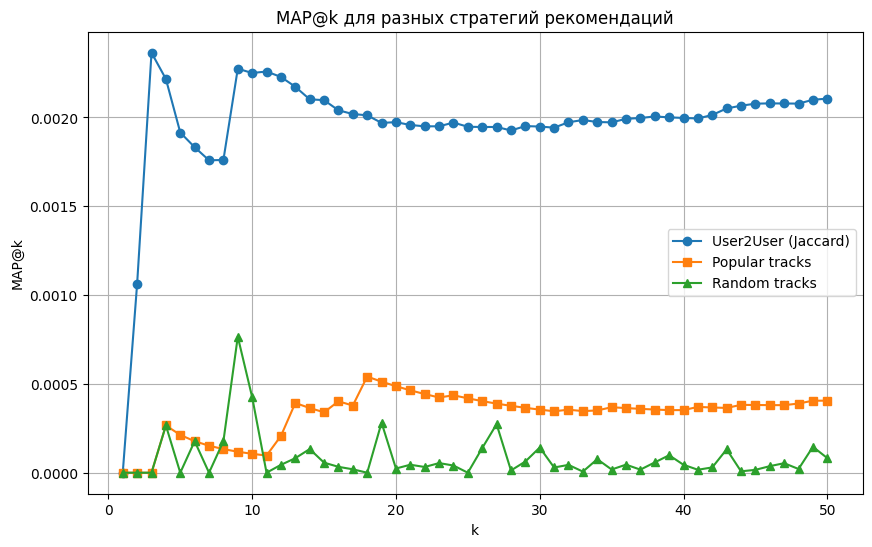

In [482]:
col_filtr = User2User(train_ratings)

k_max = 50

mapk_collab= []
mapk_popular = []
mapk_random = []

for k in range(1, k_max+1):
    rec_collab = col_filtr.get_test_recommendations(k)
    rec_popular = np.array([np.argsort(-1*col_filtr.R.sum(0))[:k] for u in test_users])
    rec_random = np.random.choice(np.unique(train_ratings['trackId']), size=(len(test_users), k))

    mapk_collab.append(mapk(test_relevant, rec_collab, k))
    mapk_popular.append(mapk(test_relevant, rec_popular, k))
    mapk_random.append(mapk(test_relevant, rec_random, k))

plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), mapk_collab, label='User2User (Jaccard)', marker='o')
plt.plot(range(1, k_max + 1), mapk_popular, label='Popular tracks', marker='s')
plt.plot(range(1, k_max + 1), mapk_random, label='Random tracks', marker='^')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k для разных стратегий рекомендаций')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** Лучшим оказался способ рекомендации, основанный на мере Жаккара, он в среднем выдает метрику 0.002, тогда как рандомный подход показывает наихудший результат среди трех методов, в среднем map@k около 0.0001, но иногда бывают более удачные рекомендации (при k=9). Подход с популярными трекам при k<=10 наравне или хуже случайного подхода, но затем в среднем выдает метрику 0.0004, что в любом случае в 5 раз хуже, чем метод с мерой Жаккара.

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
class BaseModel_sparse:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = csr_matrix((np.ones(len(ratings)), (ratings['userId'], ratings['trackId'])), shape=(self.n_users, self.n_items))

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user in range(self.n_users):
            test_preds.append(self.recommend(user))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

In [ ]:
def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    ratings_bin = ratings.astype(bool)
    user_bin = user_vector.astype(bool)

    intersection = ratings_bin.multiply(user_bin).sum(axis=1).A1
    union = ratings_bin.sum(axis=1).A1 + user_bin.sum() - intersection
    similarity = intersection/union
    similarity[union == 0] = 0

    return similarity

In [ ]:
class User2User_sparse(BaseModel_sparse):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard_sparse
        self.alpha = 0.02

    def similarity(self, user_vector: csr_matrix):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        sim[uid] = 0
        sim_users_indexes = np.where(sim > self.alpha)[0]

        return np.argsort(-sim[sim_users_indexes] @ self.R[sim_users_indexes])

In [485]:
import time

start = time.time()
model_dense = User2User(train_ratings)
recs_dense = model_dense.get_test_recommendations(15)
print(f'Оригинальный подход: {time.time() - start:.2f} сек')

start = time.time()
model_sparse = User2User_sparse(train_ratings)
recs_sparse = model_sparse.get_test_recommendations(15)
print(f"Разреженный подход: {time.time() - start:.2f} сек")

assert np.allclose(recs_dense, recs_sparse)

Оригинальный подход: 43.54 сек
Разреженный подход: 1.37 сек


**Вывод:** время работы снизилось в 32 раза.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [600]:
user_id = np.random.randint(0, col_filtr.n_users)

In [601]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
5517,Варвара,['Би-2']
6243,Thank You,['Dido']
7767,ариведерчи,['Земфира']
11525,Stereo Hearts,"['Gym Class Heroes', 'Adam Levine']"
17348,Её глаза,['Би-2']
18235,Drunk in Love,"['Beyoncé', 'Jay-Z']"
18461,No More,"['Gorgon City', 'Liv']"
19142,Напитки покрепче,['Звери']
19157,Для тебя,['Звери']
20361,Imagination,"['Gorgon City', 'Katy Menditta']"


In [602]:
preds = col_filtr.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
1137,Nothing Else Matters,['Metallica']
2555,Californication,['Red Hot Chili Peppers']
164,My Favourite Game,['The Cardigans']
5520,Серебро,['Би-2']
1073,Smells Like Teen Spirit,['Nirvana']
2941,Supermassive Black Hole,"['Muse', 'Matthew Bellamy', 'Dominic Howard', ..."
40390,In My Mind,"['Dynoro', ""Gigi D'Agostino""]"
41502,In the End,"['Tommee Profitt', 'Fleurie', 'Jung Youth']"
24500,Way Down We Go,['KALEO']
33436,Believer,['Imagine Dragons']


Рекомендации получились не очень хорошими, однако есть совпадения по жанру рок, хотя в рекомендациях он более тяжелый. Также рекомендация Серебро ['Би-2'] в данном случае соответствует музыкальным предпочтениям пользователя и созвучна уже с прослушанными композициями.

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Сэмплируем $(u, i)$ из $R$ так, что $r_{ui} \neq 0$

Градиент по $p_u$:

$\nabla_{p_u} L = 2(p_u^\top q_i - r_{ui}) q_i + 2\lambda p_u$

Градиент по $q_i$:

$\nabla_{q_i} L = 2(q_i^\top p_u - r_{ui}) p_u + 2\lambda q_i$

**Ответ:**

Обновление $p_u$:

$p_u = p_u - \eta ((p_u^\top q_i - r_{ui}) q_i + \lambda p_u)$

Обновление $q_i$:

$q_i = q_i - \eta ((q_i^\top p_u - r_{ui}) p_u + \lambda q_i)$

**ALS:**

Для фиксированного $Q$, берём градиент по $p_u$ и приравниваем к нулю:

$\nabla_{p_u} L = 2\sum_{i} (p_u^\top q_i - r_{ui}) q_i + 2\lambda p_u = 0$

Не забываем проверить, что $r_{ui} \neq 0$

Воспользовавшись тем, что $a^\top b c = c b^\top a$, получим:

$\sum_{i} q_i q_i^\top p_u + \lambda p_u = \sum_{i} r_{ui} q_i$

Вынесем $p_u$:

$\left( \sum_{i} q_i q_i^\top + \lambda I \right) p_u = \sum_{i} r_{ui} q_i$

**Ответ:**

Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле:

$p_u = \left( \sum_{i} q_i q_i^\top + \lambda I \right)^{-1} \left( \sum_{i} r_{ui} q_i \right) \quad \forall u$

Аналогично для столбцов матрицы $Q$:

$q_i = \left( \sum_{u} p_u p_u^\top + \lambda I \right)^{-1} \left( \sum_{u} r_{ui} p_u \right) \quad \forall i$

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
import random

class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als', 'ials']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01
        self.alpha = 50

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                nonzero_indices = np.array(self.R.nonzero()).T

                u, i = nonzero_indices[np.random.randint(len(nonzero_indices))]
                r_ui = self.R[u, i]

                self.P[u] -= self.lr * ((self.P[u] @ self.Q[i] - r_ui) * self.Q[i] + self.lamb * self.P[u])
                self.Q[i] -= self.lr * ((self.P[u] @ self.Q[i] - r_ui) * self.P[u] + self.lamb * self.Q[i])

            elif self.mode == 'als':
                for u in range(self.n_users):
                    nonzero_indices = self.R[u, :] > 0
                    Q_i = self.Q[nonzero_indices]
                    R_u = self.R[u, nonzero_indices]

                    if len(R_u) > 0:
                        self.P[u] = np.linalg.solve(Q_i.T @ Q_i + self.lamb * np.eye(self.dim), Q_i.T @ R_u)

                for i in range(self.n_items):
                    nonzero_indices = self.R[:, i] > 0
                    P_u = self.P[nonzero_indices]
                    R_i = self.R[nonzero_indices, i]

                    if len(R_i) > 0:
                        self.Q[i] = np.linalg.solve(P_u.T @ P_u + self.lamb * np.eye(self.dim), P_u.T @ R_i)

            elif self.mode == 'ials':
                for u in range(self.n_users):
                    r_u = self.R[u]
                    c_u = 1 + self.alpha * r_u
                    y_u = (r_u > 0).astype(float)

                    self.P[u] = np.linalg.solve((self.Q.T*c_u) @ self.Q + self.lamb * np.eye(self.dim), (self.Q.T*c_u) @ y_u)

                for i in range(self.n_items):
                    r_i = self.R[:, i]
                    c_i = 1 + self.alpha * r_i
                    y_i = (r_i > 0).astype(float)

                    self.Q[i] = np.linalg.solve((self.P.T*c_i) @ self.P + self.lamb * np.eye(self.dim), (self.P.T*c_i) @ y_i)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [625]:
num_iters_range = np.arange(5, 206, 10)
dim_values = [32, 64, 96, 128, 192, 256]
k_values = np.arange(1, 51)

results = []

for num_iters in num_iters_range:
    print(f"\nДля num_iters = {num_iters}")

    best_overall = {
        'map@k': -1,
        'dim': None,
        'k': None
    }

    for dim in dim_values:
        print(f"\ndim = {dim}")

        lfm = LatentFactorModel(train_ratings, dim=dim, mode='sgd')
        lfm.fit(num_iters)

        predictions = lfm.get_test_recommendations(k=50)

        for k in k_values:
            score = mapk(test_relevant, predictions, k)

            if score > best_overall['map@k']:
                best_overall.update({
                    'map@k': score,
                    'dim': dim,
                    'k': k
                })

    print('\nНаивысший map@k для данного num_iters:', best_overall['map@k'])

    results.append({
        'num_iters': num_iters,
        'dim': best_overall['dim'],
        'k': best_overall['k'],
        'map@k': best_overall['map@k']
    })

results_df = pd.DataFrame(results)

best_row = results_df.loc[results_df['map@k'].idxmax()]
print("\nBest overall:")
print(best_row)


Для num_iters = 5

dim = 32


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/5 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 15

dim = 32


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/15 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 25

dim = 32


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/25 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 35

dim = 32


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/35 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0003375126646403242

Для num_iters = 45

dim = 32


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/45 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 55

dim = 32


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/55 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 65

dim = 32


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/65 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00017021276595744682

Для num_iters = 75

dim = 32


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/75 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 85

dim = 32


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/85 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00017021276595744682

Для num_iters = 95

dim = 32


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/95 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 105

dim = 32


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/105 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 115

dim = 32


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/115 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 125

dim = 32


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/125 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 135

dim = 32


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/135 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 145

dim = 32


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/145 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 155

dim = 32


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/155 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 165

dim = 32


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/165 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 175

dim = 32


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/175 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 185

dim = 32


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/185 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 195

dim = 32


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/195 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00026595744680851064

Для num_iters = 205

dim = 32


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/205 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Best overall:
num_iters    105.000000
dim           32.000000
k              1.000000
map@k          0.004255
Name: 10, dtype: float64


In [ ]:
num_iters_range = np.arange(5, 206, 20)
dim_values = [16, 32, 64, 96]
k_values = np.arange(1, 51)

results = []

for num_iters in num_iters_range:
    print(f"\nДля num_iters = {num_iters}")

    best_overall = {
        'map@k': -1,
        'dim': None,
        'k': None
    }

    for dim in dim_values:
        print(f"\ndim = {dim}")

        lfm = LatentFactorModel(train_ratings, dim=dim, mode='als')
        lfm.fit(num_iters)

        predictions = lfm.get_test_recommendations(k=50)

        for k in k_values:
            score = mapk(test_relevant, predictions, k)

            if score > best_overall['map@k']:
                best_overall.update({
                    'map@k': score,
                    'dim': dim,
                    'k': k
                })

    print('\nНаивысший map@k для данного num_iters:', best_overall['map@k'])

    results.append({
        'num_iters': num_iters,
        'dim': best_overall['dim'],
        'k': best_overall['k'],
        'map@k': best_overall['map@k']
    })

results_df_als = pd.DataFrame(results)

best_row_als = results_df_als.loc[results_df_als['map@k'].idxmax()]
print("\nBest overall:")
print(best_row_als)


Для num_iters = 5

dim = 16


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/5 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 25

dim = 16


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/25 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00851063829787234

Для num_iters = 45

dim = 16


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/45 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00851063829787234

Для num_iters = 65

dim = 16


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/65 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.01276595744680851

Для num_iters = 85

dim = 16


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/85 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 105

dim = 16


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/105 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00851063829787234

Для num_iters = 125

dim = 16


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/125 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 145

dim = 16


  0%|          | 0/145 [00:00<?, ?it/s]

KeyboardInterrupt: 

Я дождался только до 125 итераций, ALS какой-то долгий.

In [ ]:
results_df_als = pd.DataFrame(results)

best_row_als = results_df_als.loc[results_df_als['map@k'].idxmax()]
print("\nBest overall:")
print(best_row_als)


Best overall:
num_iters    65.000000
dim          64.000000
k             1.000000
map@k         0.012766
Name: 3, dtype: float64


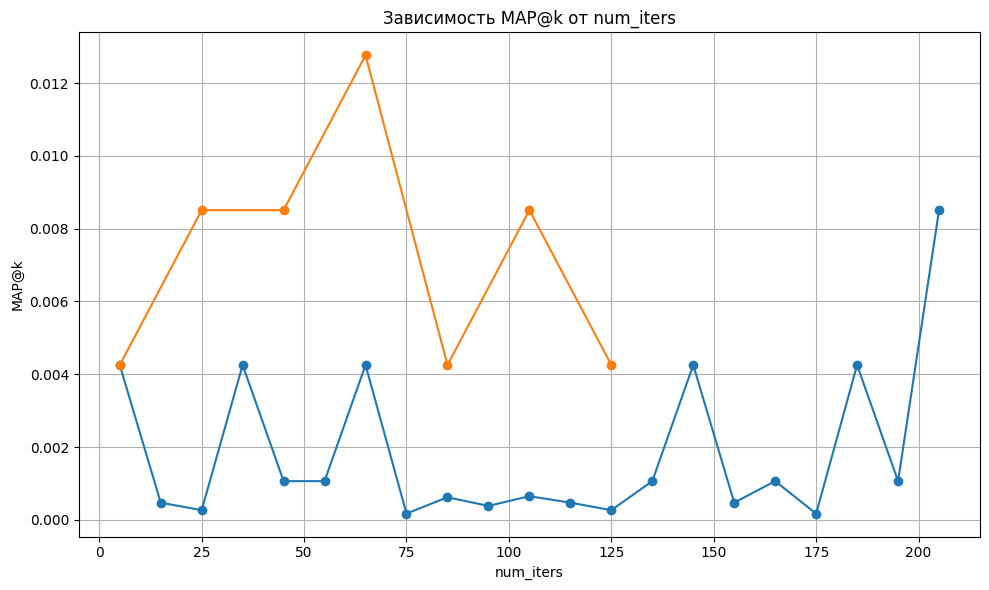

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_iters'], results_df['map@k'], marker='o', linestyle='-')
plt.plot(results_df_als['num_iters'], results_df_als['map@k'], marker='o', linestyle='-')
plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.title('Зависимость MAP@k от num_iters')
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:** По графику видно, что ALS показывает себя намного лучше SGD, который в некоторых моментах дает MAP@K близкий к нулю, а все остальные значения лежат не выше, чем любое значение метрики у ALS, кроме значения SGD > 0.008 на 200 итераций. Максимальное значение у ALS > 0.012, что в несколько раз превосходит максимальное значение у User2User. Таким образом, SGD только в половине случаев лучше, чем случайные рекомендации и User2User, но в этих случаях разница значительная (примерно в 2 раза для максимального MAP@K у User2User). ALS же даже в самых худших случаях показывает метрику в два раза выше, чем максимальная у User2User. Зависимость от количества итераций не очень очевидна, но можно заметить, что для SGD при 75-125 итераций метрика очень мала, но достигает пика после 200 итераций. Для ALS оптимальным кажется значение от 25 до 65 итераций.

Для данной задачи более подходящим кажется алгоритм ALS, так как он демонстрирует стабильные результаты при меньшем числе итераций и менее чувствителен к выбору гиперпараметров.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
model = LatentFactorModel(train_ratings, dim=int(best_row_als['dim']), mode='als')
model.fit(int(best_row_als['num_iters']))

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.618704
2179,Восьмиклассница,['КИНО'],0.559896
9433,В последнюю осень,['ДДТ'],0.543373
31388,Мой рок-н-ролл,"['Би-2', 'Чичерина']",0.533966
5515,Романс,['Сплин'],0.498995
19430,Вечная молодость,['Чиж & Co'],0.497706
14871,Никто не услышит (Ой-йо),['ЧайФ'],0.497303
9444,Ветер,['ДДТ'],0.496497
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.493584


**Вывод:** Видим, что получилось намного лучше: есть одна рекомендация от того же автора, большинство предложенных треков относятся к русскому року, как и жанр исходного трека. Такие группы в рекомендациях как КИНО, ДДТ, Би-2, Наутилус Помпилиус говорит о хорошем семантическом попадании. Также в списке встречаются композиции от западных рок-групп, что добавляет разнообразия, но при этом сохраняет жанровую близость.

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [603]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.3 MB/s eta 0:00:00


In [605]:
import optuna

def objective(trial):
    num_iters = trial.suggest_int('num_iters', 5, 100, step=10)
    dim = trial.suggest_categorical('dim', [8, 16, 32, 64, 96])

    lfm = LatentFactorModel(train_ratings, dim=dim, mode='ials')
    lfm.fit(num_iters)

    predictions = lfm.get_test_recommendations(k=50)

    best_score = -1
    for k in range(1, 51):
        score = mapk(test_relevant, predictions, k)
        if score > best_score:
            best_score = score

    return best_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2025-06-14 14:18:38,666] A new study created in memory with name: no-name-c392bc53-833c-499c-9d5a-54028cd3118d


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-06-14 14:19:09,438] Trial 0 finished with value: 0.001288416075650118 and parameters: {'num_iters': 5, 'dim': 8}. Best is trial 0 with value: 0.001288416075650118.


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-06-14 14:47:15,638] Trial 1 finished with value: 0.00425531914893617 and parameters: {'num_iters': 35, 'dim': 64}. Best is trial 1 with value: 0.00425531914893617.


  0%|          | 0/85 [00:00<?, ?it/s]

[I 2025-06-14 14:55:08,459] Trial 2 finished with value: 0.00851063829787234 and parameters: {'num_iters': 85, 'dim': 8}. Best is trial 2 with value: 0.00851063829787234.


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-06-14 15:41:04,263] Trial 3 finished with value: 0.00425531914893617 and parameters: {'num_iters': 35, 'dim': 96}. Best is trial 2 with value: 0.00851063829787234.


  0%|          | 0/85 [00:00<?, ?it/s]

[I 2025-06-14 17:33:31,100] Trial 4 finished with value: 0.00425531914893617 and parameters: {'num_iters': 85, 'dim': 96}. Best is trial 2 with value: 0.00851063829787234.


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2025-06-14 17:39:36,810] Trial 5 finished with value: 0.01702127659574468 and parameters: {'num_iters': 65, 'dim': 8}. Best is trial 5 with value: 0.01702127659574468.


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-06-14 18:07:44,690] Trial 6 finished with value: 0.00425531914893617 and parameters: {'num_iters': 35, 'dim': 64}. Best is trial 5 with value: 0.01702127659574468.


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2025-06-14 18:17:24,580] Trial 7 finished with value: 0.00425531914893617 and parameters: {'num_iters': 65, 'dim': 16}. Best is trial 5 with value: 0.01702127659574468.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-06-14 18:17:57,973] Trial 8 finished with value: 0.00851063829787234 and parameters: {'num_iters': 5, 'dim': 8}. Best is trial 5 with value: 0.01702127659574468.


  0%|          | 0/45 [00:00<?, ?it/s]

[I 2025-06-14 18:24:35,764] Trial 9 finished with value: 0.00425531914893617 and parameters: {'num_iters': 45, 'dim': 16}. Best is trial 5 with value: 0.01702127659574468.


In [608]:
best_trial = study.best_trial

print("Лучшие параметры:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

Лучшие параметры:
num_iters: 65
dim: 8


**Вывод:** IALS смог выдать наивысшее значение метрики в 0.017 (при параметрах num_iters = 65, dim = 8), что на треть выше, чем максимальное значение у обычного ALS в 0.012. Таким образом, алгоритм IALS работает эффективнее, так как учитывет нулевые значения матрицы R, но по этой причине он работает дольше по времени, поэтому я решил не строить график в зависимости MAP@K от количества итераций, а просто подобрать оптимальные параметры через optuna.

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [239]:
lfm = LatentFactorModel(train_ratings, 64, mode='als')
lfm.fit(65)

u2u = User2User(train_ratings)

  0%|          | 0/65 [00:00<?, ?it/s]

In [245]:
lfm_predictions = lfm.get_test_recommendations(100)
user2user_predictions = u2u.get_test_recommendations(100)

In [246]:
lfm_predictions.shape == user2user_predictions.shape

True

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [247]:
test_users = test_ratings['userId'].unique()

candidate_pairs = []

for idx, (lfm_recs, u2u_recs) in enumerate(zip(lfm_predictions, user2user_predictions)):
    user_id = test_users[idx]
    for track_id in set(list(lfm_recs) + list(u2u_recs)):
        candidate_pairs.append((user_id, track_id))

train = pd.DataFrame(candidate_pairs, columns=['userId', 'trackId'])

In [248]:
train['cosine_distance'] = 1 - np.sum(lfm.P[train['userId']]*lfm.Q[train['trackId']], axis=1) / ((np.linalg.norm(lfm.P[train['userId']], axis=1) * np.linalg.norm(lfm.Q[train['trackId']], axis=1)))

In [249]:
u2sim = {}

for u in range(u2u.R.shape[0]):
    sim_vector = u2u.similarity(u2u.R[u])
    sim_vector[u] = 0
    u2sim[u] = np.mean(sim_vector)

train['user_avg_similarity'] = train['userId'].map(u2sim)

In [250]:
track_popularity = train_ratings.groupby('trackId')['userId'].nunique()/train_ratings['userId'].nunique()

train['track_popularity'] = train['trackId'].map(track_popularity)

In [251]:
user_activity = train_ratings.groupby('userId')['trackId'].nunique()

train['user_track_count'] = train['userId'].map(user_activity)

In [287]:
last50 = test_ratings.groupby('userId').tail(50)
last50_set = set(zip(last50['userId'], last50['trackId']))

train['y'] = train.apply(lambda x: int((x['userId'], x['trackId']) in last50_set), axis=1)

In [288]:
train.head(10)

,userId,trackId,cosine_distance,user_avg_similarity,track_popularity,user_track_count,y
0,0,15872,0.735190,0.003435,0.103734,206,0
1,0,14853,0.893254,0.003435,0.012448,206,0
2,0,17926,0.922725,0.003435,0.045643,206,0
3,0,46089,0.665325,0.003435,0.082988,206,0
4,0,50185,0.670769,0.003435,0.037344,206,0
5,0,1034,0.973438,0.003435,0.008299,206,0
6,0,23565,0.727772,0.003435,0.049793,206,0
7,0,25616,0.704249,0.003435,0.062241,206,0
8,0,28181,0.743528,0.003435,0.049793,206,0
9,0,6170,0.990403,0.003435,0.012448,206,0


In [289]:
from sklearn.model_selection import train_test_split

X = train.drop(columns='y')
y = train['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=52)

In [290]:
round(sum(y_train)/len(y_train), 3) == round(sum(y_test)/len(y_test), 3)

True

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [292]:
sort_indexes = np.argsort(X_train['userId'])
X_train = X_train.iloc[sort_indexes].reset_index(drop=True)
y_train = y_train.iloc[sort_indexes].reset_index(drop=True)

sort_indexes = np.argsort(X_test['userId'])
X_test = X_test.iloc[sort_indexes].reset_index(drop=True)
y_test = y_test.iloc[sort_indexes].reset_index(drop=True)

In [258]:
!pip install catboost

In [293]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train['userId'])
test_pool = catboost.Pool(X_test, y_test, group_id=X_test['userId'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [298]:
from catboost import CatBoostClassifier

catboostclass = CatBoostClassifier(iterations=2000)
catboostclass.fit(train_pool)

Learning rate set to 0.022348
0:	learn: 0.6251551	total: 13.2ms	remaining: 26.4s
1:	learn: 0.5686241	total: 24ms	remaining: 23.9s
2:	learn: 0.5151312	total: 34.7ms	remaining: 23.1s
3:	learn: 0.4666573	total: 46.8ms	remaining: 23.4s
4:	learn: 0.4258246	total: 58.2ms	remaining: 23.2s
5:	learn: 0.3899894	total: 70.5ms	remaining: 23.4s
6:	learn: 0.3525179	total: 81.8ms	remaining: 23.3s
7:	learn: 0.3233121	total: 91.6ms	remaining: 22.8s
8:	learn: 0.2930585	total: 102ms	remaining: 22.6s
9:	learn: 0.2660245	total: 112ms	remaining: 22.3s
10:	learn: 0.2433867	total: 123ms	remaining: 22.2s
11:	learn: 0.2218990	total: 138ms	remaining: 22.9s
12:	learn: 0.2032434	total: 164ms	remaining: 25.1s
13:	learn: 0.1868323	total: 193ms	remaining: 27.4s
14:	learn: 0.1714837	total: 233ms	remaining: 30.8s
15:	learn: 0.1580516	total: 259ms	remaining: 32.1s
16:	learn: 0.1463209	total: 286ms	remaining: 33.4s
17:	learn: 0.1356503	total: 319ms	remaining: 35.1s
18:	learn: 0.1253319	total: 343ms	remaining: 35.8s
19:	l

In [609]:
predictions = []

for user_id, user_data in X_test.groupby('userId'):
    probs = catboostclass.predict_proba(user_data)[:, 1]

    user_data = user_data.copy()
    user_data['prob'] = probs
    top_tracks = user_data.sort_values('prob', ascending=False)['trackId'].tolist()

    predictions.append(top_tracks)

In [610]:
test_users_all = test_ratings['userId'].unique()

lfm_pred_df = pd.DataFrame([
    {'userId': user_id, 'preds': preds}
    for user_id, preds in zip(test_users_all, lfm_predictions)
])

u2u_pred_df = pd.DataFrame([
    {'userId': user_id, 'preds': preds}
    for user_id, preds in zip(test_users_all, user2user_predictions)
])

final_test_users = X_test['userId'].unique()
lfm_pred_df = lfm_pred_df[lfm_pred_df['userId'].isin(final_test_users)].reset_index(drop=True)
u2u_pred_df = u2u_pred_df[u2u_pred_df['userId'].isin(final_test_users)].reset_index(drop=True)

ground_truth = (test_ratings.groupby('userId')['trackId'].apply(list).to_dict())

test_relevant_new = [ground_truth.get(user_id, []) for user_id in lfm_pred_df['userId']]

lfm_predictions = lfm_pred_df['preds'].tolist()
user2user_predictions = u2u_pred_df['preds'].tolist()

In [611]:
map20_catboostclass = mapk(test_relevant_new, predictions, k=20)
map20_lfm = mapk(test_relevant_new, lfm_predictions, k=20)
map20_u2u = mapk(test_relevant_new, user2user_predictions, k=20)
print(f'MAP@20 (CatBoostClassifier): {map20_catboostclass:.4f}')
print(f'MAP@20 (LFM): {map20_lfm:.4f}')
print(f'MAP@20 (User2User): {map20_u2u:.4f}')

MAP@20 (CatBoostClassifier): 0.0066
MAP@20 (LFM): 0.0006
MAP@20 (User2User): 0.0020


**Вывод:** Результаты удалось существенно улучшить, однако проблема данного задания заключается в отсутствии временной метки, что не позволяет точно определить 50 последних прослушанных треков для формирования целевой переменной. Вместо этого приходится опираться на порядок записей в датасете, отсортированном по индексам, что снижает точность таргета.

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [380]:
from catboost import CatBoostRanker

catboostrank = CatBoostRanker(iterations=2000, loss_function='YetiRank')
catboostrank.fit(train_pool)

0:	total: 198ms	remaining: 6m 35s
1:	total: 489ms	remaining: 8m 8s
2:	total: 741ms	remaining: 8m 13s
3:	total: 921ms	remaining: 7m 39s
4:	total: 1.1s	remaining: 7m 19s
5:	total: 1.23s	remaining: 6m 48s
6:	total: 1.41s	remaining: 6m 41s
7:	total: 1.59s	remaining: 6m 36s
8:	total: 1.71s	remaining: 6m 17s
9:	total: 1.86s	remaining: 6m 9s
10:	total: 2s	remaining: 6m 1s
11:	total: 2.15s	remaining: 5m 56s
12:	total: 2.29s	remaining: 5m 50s
13:	total: 2.45s	remaining: 5m 48s
14:	total: 2.59s	remaining: 5m 43s
15:	total: 2.7s	remaining: 5m 35s
16:	total: 2.81s	remaining: 5m 27s
17:	total: 2.92s	remaining: 5m 22s
18:	total: 3.04s	remaining: 5m 16s
19:	total: 3.22s	remaining: 5m 18s
20:	total: 3.34s	remaining: 5m 15s
21:	total: 3.46s	remaining: 5m 10s
22:	total: 3.58s	remaining: 5m 8s
23:	total: 3.69s	remaining: 5m 3s
24:	total: 3.8s	remaining: 5m
25:	total: 3.92s	remaining: 4m 57s
26:	total: 4.04s	remaining: 4m 55s
27:	total: 4.16s	remaining: 4m 52s
28:	total: 4.27s	remaining: 4m 50s
29:	total:

In [381]:
predictions = []

for user_id, user_data in X_test.groupby('userId'):
    ranks = catboostrank.predict(user_data)

    user_data = user_data.copy()
    user_data['rank'] = ranks
    top_tracks = user_data.sort_values('rank', ascending=False)['trackId'].tolist()

    predictions.append(top_tracks)

In [385]:
map20_catboostrank = mapk(test_relevant_new, predictions, k=20)
map20_lfm = mapk(test_relevant_new, lfm_predictions, k=20)
map20_u2u = mapk(test_relevant_new, user2user_predictions, k=20)
print(f'MAP@20 (CatBoostRanker): {map20_catboostrank:.4f}')
print(f'MAP@20 (LFM): {map20_lfm:.4f}')
print(f'MAP@20 (User2User): {map20_u2u:.4f}')

MAP@20 (CatBoostRanker): 0.0055
MAP@20 (LFM): 0.0006
MAP@20 (User2User): 0.0020


**Вывод:** Результаты также удалось улучшить по сравнению с LFM и User2User, однако CatBoostClassifier выдал метрику несколько лучше, но не забываем про неточность таргета в данном задании из-за отсутствия временной метки.